# Task 5 · Consumer Complaint Text Classification

**Goal:** Classify consumer complaints into 4 categories:

0 — Credit reporting, repair, or other  
1 — Debt collection  
2 — Consumer Loan  
3 — Mortgage  

**Pipeline steps:**
1. Exploratory Data Analysis (EDA) & Feature Engineering  
2. Text Pre-Processing  
3. Selection of Multi-Classification Model  
4. Comparison of Model Performance  
5. Model Evaluation  
6. Prediction  

## Setup & Paths

In [10]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

DATA_PATH = "data/ccdb_balanced.csv"

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

CANON_TO_ID = {
    "Credit reporting, repair, or other": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3,
}
ID_TO_CANON = {v: k for k, v in CANON_TO_ID.items()}

## 1) Exploratory Data Analysis (EDA) & Feature Engineering

Rows: 39474
Columns: ['text', 'canon_product']

Class distribution (canon_product):
canon_product
Credit reporting, repair, or other    10000
Debt collection                       10000
Mortgage                              10000
Consumer Loan                          9474
Name: count, dtype: int64

Token length stats:
count    39474.000000
mean       201.449410
std        207.537034
min          1.000000
25%         73.000000
50%        140.000000
75%        260.000000
max       5729.000000
Name: tokens, dtype: float64


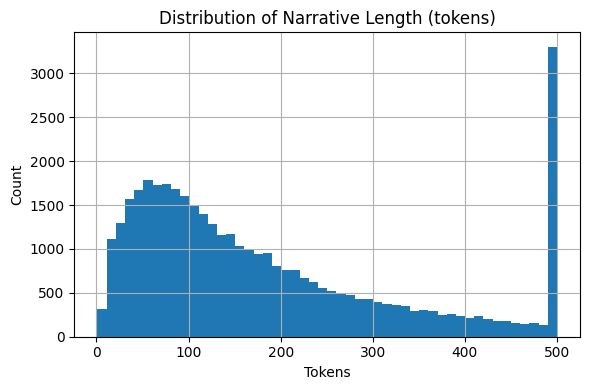

In [11]:
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))
print("Columns:", list(df.columns))

print("\nClass distribution (canon_product):")
print(df["canon_product"].value_counts())

df["tokens"] = df["text"].astype(str).str.split().str.len()
print("\nToken length stats:")
print(df["tokens"].describe())

plt.figure(figsize=(6,4))
df["tokens"].clip(0, 500).hist(bins=50)
plt.title("Distribution of Narrative Length (tokens)")
plt.xlabel("Tokens"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 2) Text Pre-Processing

In [12]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["label"] = df["canon_product"].map(CANON_TO_ID)
df["clean"] = df["text"].astype(str).apply(clean_text)

df = df[df["clean"].str.split().str.len() >= 4].reset_index(drop=True)

print("After cleaning, rows:", len(df))
print("\nClass distribution after cleaning:")
print(df["canon_product"].value_counts())

After cleaning, rows: 39463

Class distribution after cleaning:
canon_product
Mortgage                              10000
Credit reporting, repair, or other     9997
Debt collection                        9994
Consumer Loan                          9472
Name: count, dtype: int64


## 3) Selection of Multi-Classification Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

models = {
    "Linear SVM": LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
}

print("Vectorized shapes:", Xtr.shape, Xte.shape)

Vectorized shapes: (31570, 5000) (7893, 5000)


## 4) Comparison of Model Performance

=== Model Comparison ===


,Model,Accuracy,F1-macro,F1-weighted
1,Logistic Regression,0.850120,0.849760,0.850021
4,SGD Classifier,0.846066,0.845517,0.845808
0,Linear SVM,0.843532,0.843164,0.843387
3,Random Forest,0.837958,0.837473,0.837817
2,Naive Bayes,0.818700,0.817467,0.818006


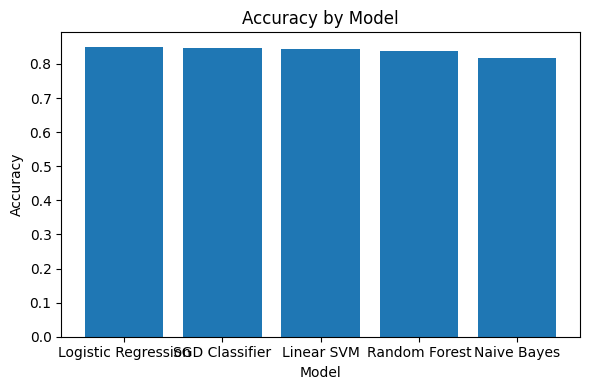

In [14]:
results = []
reports = {}

for name, model in models.items():
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    results.append({"Model": name, "Accuracy": acc, "F1-macro": f1_macro, "F1-weighted": f1_weighted})
    reports[name] = classification_report(
        y_test, y_pred,
        target_names=[ID_TO_CANON[i] for i in sorted(ID_TO_CANON)],
        digits=4
    )

comparison_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("=== Model Comparison ===")
display(comparison_df)

plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["Accuracy"])
plt.title("Accuracy by Model")
plt.xlabel("Model"); plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

## 5) Model Evaluation

Best model: Logistic Regression

                                    precision    recall  f1-score   support

Credit reporting, repair, or other     0.8375    0.8170    0.8271      2000
                   Debt collection     0.8035    0.8264    0.8148      1999
                     Consumer Loan     0.8378    0.8237    0.8307      1894
                          Mortgage     0.9209    0.9320    0.9264      2000

                          accuracy                         0.8501      7893
                         macro avg     0.8499    0.8498    0.8498      7893
                      weighted avg     0.8501    0.8501    0.8500      7893



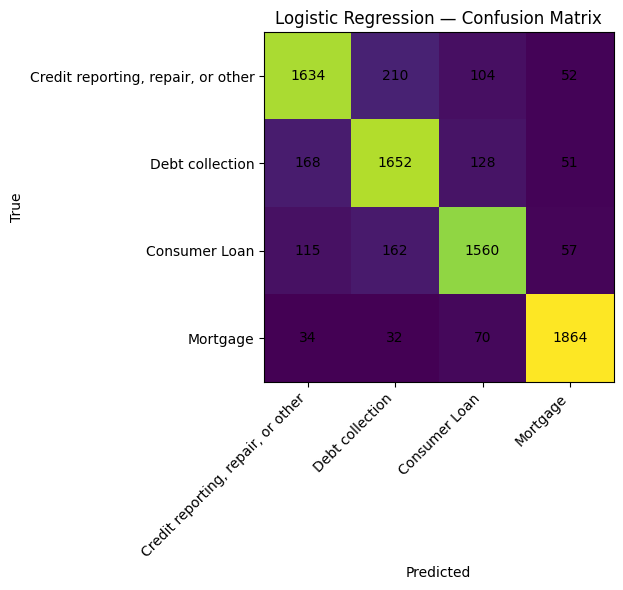

In [15]:
best_name = comparison_df.iloc[0]["Model"]
best_model = models[best_name]

y_pred = best_model.predict(Xte)

print(f"Best model: {best_name}\n")
print(reports[best_name])

labels = [0,1,2,3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
tick_labels = [ID_TO_CANON[i] for i in labels]

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"{best_name} — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(labels)), tick_labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), tick_labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

## 6) Prediction (Save Artifacts & Inference Demo)

In [16]:
import joblib

joblib.dump(best_model, os.path.join(ARTIFACTS_DIR, "best_model.joblib"))
joblib.dump(tfidf, os.path.join(ARTIFACTS_DIR, "tfidf.joblib"))
df.to_csv(os.path.join(ARTIFACTS_DIR, "training_data_sample.csv"), index=False)
print("Saved artifacts to:", ARTIFACTS_DIR)

def predict_text(texts):
    cleaned = [re.sub(r"\s+"," ", re.sub(r"[^a-z\s]"," ", t.lower())).strip() for t in texts]
    X = tfidf.transform(cleaned)
    preds = best_model.predict(X)
    return [ID_TO_CANON[p] for p in preds]

demo = [
    "They keep reporting wrong information on my credit report.",
    "A debt collector is calling me multiple times a day.",
    "The mortgage company applied my escrow payment incorrectly.",
    "My consumer loan application had incorrect interest disclosures."
]
print("\nDemo predictions:")
for t, p in zip(demo, predict_text(demo)):
    print(f"- {p} :: {t}")

Saved artifacts to: artifacts

Demo predictions:
- Credit reporting, repair, or other :: They keep reporting wrong information on my credit report.
- Debt collection :: A debt collector is calling me multiple times a day.
- Mortgage :: The mortgage company applied my escrow payment incorrectly.
- Consumer Loan :: My consumer loan application had incorrect interest disclosures.
